<a href="https://colab.research.google.com/github/cocoyuy/recommendation-systems/blob/main/MF_in_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports the MovieLens-100K dataset

In [ ]:
# download ml-100k dataset from the official website:
! wget https://files.grouplens.org/datasets/movielens/ml-100k.zip; unzip ml-100k.zip

--2024-02-22 05:25:15--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  29.0MB/s    in 0.2s    

2024-02-22 05:25:15 (29.0 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.ba

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook
from copy import deepcopy

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

## Data Processing

There are several pre-defined training and validation set from the `ml-100k` dataset. We will use the split where each user has exactly 10 ratings in the test set(`ua.base` and `ua.test`). The training set consists of 90,570 user-item-rating tuples and the validation set consists of 9,430 such tuples.

In [ ]:
user_cnts = 943 #total number of users
item_cnts = 1682 #total number of items

In [ ]:
# we fisrt tranform the user and item index to start from 0.
train_df = pd.read_csv("ml-100k/ua.base", sep='\t', header=None)
train_df.columns = ['user_id','item_id','rating','ts']
train_df['user_id'] = train_df['user_id'] -1
train_df['item_id'] = train_df['item_id'] -1
valid_df = pd.read_csv("ml-100k/ua.test", sep='\t', header=None)
valid_df.columns = ['user_id','item_id','rating','ts']
valid_df['user_id'] = valid_df['user_id'] -1
valid_df['item_id'] = valid_df['item_id'] -1
train_df.shape, valid_df.shape

((90570, 4), (9430, 4))

In [ ]:
#check number of unique users in both training and test set
train_users = train_df.user_id.unique()
valid_users = valid_df.user_id.unique()
len(train_users),len(valid_users)

(943, 943)

In [ ]:
train_items = train_df.item_id.unique()
valid_items = valid_df.item_id.unique()
len(train_items),len(valid_items)

(1680, 1129)

In [ ]:
i = 0
for u in valid_items:
    if u in train_items: i+=1
i

1127

## Dataset

In [ ]:
class MovieLensDataset(Dataset):
    def __init__(self, df, user_col=0, item_col=1, rating_col=2):
        self.df = df
        self.user_tensor = torch.tensor(self.df.iloc[:,user_col], dtype=torch.long, device = device)
        self.item_tensor = torch.tensor(self.df.iloc[:,item_col], dtype=torch.long, device = device)
        self.target_tensor = torch.tensor(self.df.iloc[:,rating_col], dtype=torch.float32, device = device)

    def __getitem__(self, index):
        return(self.user_tensor[index], self.item_tensor[index], self.target_tensor[index])

    def __len__(self):
        return(self.target_tensor.shape[0])

In [ ]:
batch_size = 1000
train_ds = MovieLensDataset(train_df)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_ds = MovieLensDataset(valid_df)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

In [ ]:
len(train_ds),len(valid_ds),len(train_dl),len(valid_dl)

(90570, 9430, 91, 10)

In [ ]:
train_ds[:5], valid_ds[:20]

((tensor([0, 0, 0, 0, 0], device='cuda:0'),
  tensor([0, 1, 2, 3, 4], device='cuda:0'),
  tensor([5., 3., 4., 3., 3.], device='cuda:0')),
 (tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
         device='cuda:0'),
  tensor([ 19,  32,  60, 116, 154, 159, 170, 188, 201, 264,  12,  49, 250, 279,
          280, 289, 291, 296, 311, 313], device='cuda:0'),
  tensor([4., 4., 4., 3., 2., 4., 5., 3., 5., 4., 4., 5., 5., 3., 3., 3., 4., 4.,
          3., 1.], device='cuda:0')))

In [ ]:
next(iter(train_dl))

[tensor([109,  12, 193, 518, 386, 290, 154, 176, 836, 304, 830, 398,  89, 704,
          81, 503, 907, 310,  12,  93, 302, 517, 534, 325, 853, 486, 906, 895,
         532, 703, 523, 567, 416, 118, 591, 842, 454, 893, 600, 118, 888, 315,
         717,  98, 287,  90, 893, 298, 285, 157, 388, 902, 150,  58, 357, 633,
         685, 692, 404, 172, 268, 262, 622, 878, 377, 879,  55, 624, 922,  58,
          12, 869, 762, 450, 270, 434, 300, 639, 449, 456, 398, 300,  53, 766,
         939, 488, 795, 652, 668, 866, 640, 307, 693, 845,  71, 292, 806, 220,
         154, 662, 153, 200,  58, 406, 473, 388,  66,  61, 302, 491,  55, 255,
         298, 708, 339, 722,  12, 942, 842, 942,  71, 157, 641,  84, 492, 275,
         291, 362, 434, 436,  58, 628, 880, 370, 853, 907, 847, 628, 182, 321,
         193, 173, 528, 591, 263, 406, 300, 451, 317, 797, 757, 649, 560, 598,
         868, 755, 867, 560, 404, 456, 173, 763, 248, 429,   5, 726, 220, 543,
           0, 330, 260, 926, 449, 692, 642, 266, 233

## Collaborative Filtering through Matrix Factorization

### Architecture

The simplest form of collaborative filtering consists of the following elements:

1. **Item Embedding Layer** to convert item index to vectors
2. **User Embedding Layer** to convert user index to vectors
3. **Item Bias** to be added to the dot product
4. **User Bias** to be added to the dot product

We feed each pair of user and item indice into the layers above the perform the following operations to get the predicted rating:

$$r̂=\sum{(E_{user} * E_{item})} + B_{user} + B_{item}$$

In [ ]:
class MF(nn.Module):
    def __init__(self, config):
        super(MF, self).__init__()

        #hyperparameters
        self.config = config
        self.nb_users = config['user_cnts']
        self.nb_items = config['item_cnts']
        self.emb_dim = config['emb_dim']
        self.y_range = config['y_range']

        #embeddings
        self.emb_user = nn.Embedding(num_embeddings=self.nb_users, embedding_dim=self.emb_dim)
        self.user_bias = nn.Embedding(num_embeddings=self.nb_users, embedding_dim=1)
        self.emb_item = nn.Embedding(num_embeddings=self.nb_items, embedding_dim=self.emb_dim)
        self.item_bias = nn.Embedding(num_embeddings=self.nb_items, embedding_dim=1)


    def forward(self, user_idx, item_idx):
        user_emb = self.emb_user(user_idx) # dim: (batch_size, embed_dim)
        item_emb = self.emb_item(item_idx) # dim: (batch_size, embed_dim)
        dot = (user_emb * item_emb).sum(1) # dim: (batch_size)
        x = dot + self.user_bias(user_idx).squeeze() + self.item_bias(item_idx).squeeze()
        x = torch.sigmoid(x) # dim: (batch_size)
        x = x * (self.y_range[1] - self.y_range[0]) + self.y_range[0]
        return(x)

In [ ]:
model_config = {
    'user_cnts':943, # unique users for embedding layer
    'item_cnts':1682, # unique items for embedding layer
    'emb_dim':100, #size of embedding vector
    'y_range': [1.0,5.0]} #range of output
model = MF(model_config)
model

MF(
  (emb_user): Embedding(943, 100)
  (user_bias): Embedding(943, 1)
  (emb_item): Embedding(1682, 100)
  (item_bias): Embedding(1682, 1)
)

### Puting things together and train the model!

In [ ]:
#hyperparameters
batch_size = 1000 #batch size
lr = 1e-1 #learning rate
epochs = 100 # epochs to train
weight_decay = 1e-2 # L2 penalty (very important for this task, try different penalty weights)

model_config = {
    'user_cnts':943, # unique users for embedding layer
    'item_cnts':1682, # unique items for embedding layer
    'emb_dim':100, #size of embedding vector
    'y_range': [1.0,5.0]} #range of model predictions

#for recording training output
train_losses=[]
valid_losses = []
best_loss = np.inf
best_weights = None

#datasets/loaders
# Attention: remove num_workers to get this run on cuda. related issue: https://github.com/pytorch/pytorch/issues/21092
# more readings on multiprocess for pytorch:https://pytorch.org/docs/master/notes/multiprocessing.html#cuda-in-multiprocessing
train_ds = MovieLensDataset(train_df)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_ds = MovieLensDataset(valid_df)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

#model
model = MF(model_config)
model = model.to(device) # to make sure your model paramters are also on cuda
loss_fn = nn.MSELoss(reduction='sum')
optim = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:
for e in tqdm_notebook(range(epochs)):
    model.train()
    train_loss = 0

    # start batch training
    for u, i, r in train_dl:
        #model prediction
        r_pred = model(u,i)
        #compute loss
        loss = loss_fn(r_pred,r)
        #backprop
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss+= loss.detach().item()

    #record loss
    train_loss /= len(train_ds) # average loss over all examples.
    train_losses.append(train_loss)

    #validation
    model.eval() # this fix the trainable parameters.
    valid_loss = 0
    for u, i, r in valid_dl:
        r_pred = model(u,i)
        loss = loss_fn(r_pred,r)
        valid_loss+=loss.detach().item()

    valid_loss/=len(valid_ds)
    valid_losses.append(valid_loss)

    print(f'Epoch {e} Train loss: {train_loss}; Valid loss: {valid_loss}')

    #choose best model
    if valid_loss < best_loss:
        best_loss = valid_loss
        # you can save the current best model parameters for further training:
        # best_weights = deepcopy(model.state_dict())

<ipython-input-42-49773a3ae36e>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for e in tqdm_notebook(range(epochs)):


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 Train loss: 4.510074681099564; Valid loss: 4.214404788780819
Epoch 1 Train loss: 3.3873066835928873; Valid loss: 3.7478628763338415
Epoch 2 Train loss: 3.0065927928997427; Valid loss: 3.5188364459752783
Epoch 3 Train loss: 2.828278599415076; Valid loss: 3.3608542384676565
Epoch 4 Train loss: 2.748187420964965; Valid loss: 3.297748456451319
Epoch 5 Train loss: 2.6704244995454136; Valid loss: 3.2030524309467787
Epoch 6 Train loss: 2.610501119860674; Valid loss: 3.1475284321563493
Epoch 7 Train loss: 2.546417801730533; Valid loss: 3.055546833576352
Epoch 8 Train loss: 2.5040757049429136; Valid loss: 3.030429190416225
Epoch 9 Train loss: 2.4833468436878934; Valid loss: 3.0235593373044805
Epoch 10 Train loss: 2.447810813092601; Valid loss: 3.0071980319624867
Epoch 11 Train loss: 2.421211150182956; Valid loss: 2.9606422529493637
Epoch 12 Train loss: 2.3870896890224755; Valid loss: 2.9530046125231975
Epoch 13 Train loss: 2.361354846497357; Valid loss: 2.9399189727556667
Epoch 14 Train

Best RMSE: 1.6819604825676318


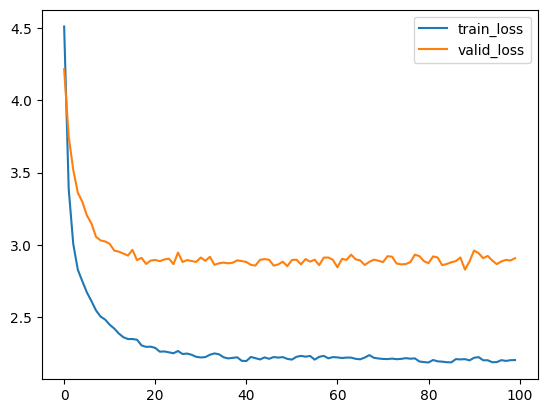

In [ ]:
plt.plot(train_losses, label='train_loss')
plt.plot(valid_losses, label='valid_loss')
plt.legend()
print(f'Best RMSE: {np.sqrt(best_loss)}')

### Item Embeddings

The useful thing about having item bias is that we can use it to rank our items, in this case, movies. Movies with more positive bias values are considered to be the "better" ones.

In [ ]:
item_df = pd.read_csv("ml-100k/u.item", delimiter='|', encoding='latin-1', header=None,
                    names=['item_id', 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
item_df = item_df[['item_id','title']].copy()
item_df['item_id'] = item_df.item_id.map(lambda x: int(x)-1)
item_df.head()

,item_id,title
0,0,Toy Story (1995)
1,1,GoldenEye (1995)
2,2,Four Rooms (1995)
3,3,Get Shorty (1995)
4,4,Copycat (1995)


In [ ]:
movie_ranking = []
for item_id in model.item_bias.weight.data.squeeze().argsort().cpu().numpy():
    movie_ranking.append((item_df.iloc[item_id,1],model.item_bias.weight.data[item_id].item()))

In [ ]:
#best rated movies
movie_ranking[::-1][:10]

[('Godfather, The (1972)', 2.2826943397521973),
 ('Shawshank Redemption, The (1994)', 2.2430996894836426),
 ("Schindler's List (1993)", 2.242823600769043),
 ('Casablanca (1942)', 2.2406160831451416),
 ('Silence of the Lambs, The (1991)', 2.2341482639312744),
 ('Star Wars (1977)', 2.1481223106384277),
 ('North by Northwest (1959)', 2.0338242053985596),
 ('Usual Suspects, The (1995)', 2.0171267986297607),
 ('Titanic (1997)', 2.0058960914611816),
 ('Vertigo (1958)', 1.90361750125885)]

In [ ]:
#worst rated movies
movie_ranking[:10]

[('Police Story 4: Project S (Chao ji ji hua) (1993)', -1.9508373737335205),
 ('Indian Summer (1996)', -1.7052966356277466),
 ('Leave It to Beaver (1997)', -1.6747022867202759),
 ('Free Willy 3: The Rescue (1997)', -1.6679917573928833),
 ('Turbo: A Power Rangers Movie (1997)', -1.6323182582855225),
 ('Free Willy 2: The Adventure Home (1995)', -1.6277214288711548),
 ('Crow: City of Angels, The (1996)', -1.559361219406128),
 ('Hostile Intentions (1994)', -1.5353333950042725),
 ('Excess Baggage (1997)', -1.5064973831176758),
 ("I'll Do Anything (1994)", -1.4722967147827148)]